In [10]:
import os
import pandas as pd
from collections import defaultdict
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from Bio import SeqIO

sns.set(font_scale=1.8, style="ticks")
month="02"

# Reading vaccine effectiveness

In [11]:
subtype_time2vaccine_strains = dict()
subtype_time2ve = dict()

for subtype in ("h3n2", "h1n1"):
    ve_path = "../../data/vaccine_effectiveness/ve_%s.csv" % subtype
    ve = pd.read_csv(ve_path)
    ve["time_bin"] = [int(year.split("-")[0]) - 2018 + 30 for year in ve["Year"]]
    ve["vaccine effectiveness"] = [x if isinstance(x, float) else float(x[:-1]) for x in ve["VE"].to_numpy()]
    ve["subtype"] = [subtype] * len(ve)
    print(ve)

    time2vaccine_strains = dict()
    time2ve = dict()

    for strains, year, eff in zip(ve["Strain"], ve["Year"], ve["vaccine effectiveness"]):
        if isinstance(eff, float) and np.isnan(eff):
            continue
        
        year = int(year.split("-")[0]) # 2018
        time2vaccine_strains[year] = strains.split("|")
        time2ve[year] = eff
    subtype_time2vaccine_strains[subtype] = time2vaccine_strains
    subtype_time2ve[subtype] = time2ve


         Year   VE   95% CI                                     Strain  \
0   2011-2012  39%  (23 52)                            A/Perth/16/2009   
1   2012-2013  39%  (29 47)                        A/Victoria/361/2011   
2   2013-2014  NaN      NaN                            A/Texas/50/2012   
3   2014-2015   6%  (-5 17)                            A/Texas/50/2012   
4   2015-2016  NaN      NaN                 A/Switzerland/9715293/2013   
5   2016-2017  33%  (23 41)                      A/Hong Kong/4801/2014   
6   2017-2018  22%  (12 31)                      A/Hong Kong/4801/2014   
7   2018-2019   9%  (-4 20)            A/Singapore/INFIMH-16-0019/2016   
8   2019-2020  NaN      NaN                           A/Kansas/14/2017   
9   2020-2021  NaN      NaN  A/Hong Kong/2671/2019|A/Hong Kong/45/2019   
10  2021-2022  36%  (21 48)                   A/Cambodia/e0826360/2020   
11  2022-2023  45%  (29 58)            A/Darwin/9/2021|A/Darwin/6/2021   

    time_bin  vaccine effectiveness s

In [12]:
models_results = defaultdict(list)

In [13]:

def get_topk_score_2(virus_dominance_path, vaccine_seq2his, candidate_vaccine_path, virus_id2seq, k=1):
    domiance_df = pd.read_csv(virus_dominance_path)
    virus_seq2dom = dict()
    for src_id, predictrion in zip(domiance_df["src_id"], domiance_df["prediction"]):
        virus_seq2dom[virus_id2seq[src_id]] = predictrion
    
    vaccine_score = []
    vaccine_id = []
    
    for record in SeqIO.parse(candidate_vaccine_path, "fasta"):
        vaccine_seq = str(record.seq)
        result = []
        for virus_seq in virus_seq2dom:
            dd = dict(vaccine_seq2his[vaccine_seq])
            if virus_seq in dd:
                hi = dd[virus_seq]
                result.append((virus_seq2dom[virus_seq], hi))
        topk_hi = sorted(result, key=lambda x: x[0])[:k]
        vaccine_score.append(np.median([x[1] for x in topk_hi]))
    vaccine_score = np.asarray(vaccine_score)[~np.isnan(vaccine_score)]
    ave_score = np.median(vaccine_score)
    return -ave_score
    

In [14]:
threshold=0.4

all_models = set()

res = defaultdict(list)

for year in range(2012, 2021):
    
    subtype2ave_scores = defaultdict(dict)
    subtype2ranking = defaultdict(dict)
    
    for subtype in ("h3n2", "h1n1"):
        if year not in subtype_time2ve[subtype]:
            continue
        virus_seq_path="../../data/gisaid/ha_processed/%d-%s_to_%d-%s_9999M/a_%s/human_minBinSize1000_lenQuantile0.2_minCnt5.fasta" % (year-3, month, year, month,subtype)
        virus_id2seq = dict()
        for record in SeqIO.parse(virus_seq_path, "fasta"):
            virus_id2seq[record.id] = str(record.seq)
            
        
        ##### Our vaccine + HI model
        who_score_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=who___virus_set=%d-%s-%d-%s/vaccine_scores" % (year, month, subtype, year-3, month, year, month)
        all_score_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=%d-%s-%d-%s___virus_set=%d-%s-%d-%s/vaccine_scores" % (year, month, subtype, year-3, month, year, month, year-3, month, year, month)

        for root, dirs, files in os.walk(who_score_path, topdown=False):
            for name in files:
                if name == "vaccine_score_and_gt.csv":
                    model_name = os.path.join(root, name).split("vaccine_scores")[1].split("vaccine_score_and_gt.csv")[0].strip("/")        
                    if model_name != "prob=weight_loss_by_count_lightning_logs_version_0___hi=max_steps_150k":
                        continue
                    
                    df_background = pd.read_csv(os.path.join(all_score_path, model_name, name))
                    df = pd.read_csv(os.path.join(root, name))

                    ave_score = -np.median(df["score"])
                    background_scores = -df_background["score"]
                    ranking = np.sum(background_scores <= ave_score) / len(background_scores)
                    model_name = "Escapability score (prediction)"
                    subtype2ave_scores[subtype][model_name] = ave_score
                    subtype2ranking[subtype][model_name] = ranking
                    all_models.add(model_name)
                    
                    # ground-truth
                    ave_score = -np.median(df[df["coverage_seq"] > threshold]["gt_score_seq"])                    
                    background_scores = -df_background["gt_score_seq"][df_background["coverage_seq"] > threshold]
                    ranking = np.sum(background_scores <= ave_score) / len(background_scores)
                    model_name = "Escapability score"
                    subtype2ave_scores[subtype][model_name] = ave_score
                    subtype2ranking[subtype][model_name] = ranking
                    all_models.add(model_name)
        
        
        ##### Dominance only
        dominance_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=who___virus_set=who/dominance_prediction" % (year, month, subtype)
        if not os.path.exists(dominance_path):
            print("Fail to find", dominance_path)
            continue

        for root, dirs, files in os.walk(dominance_path, topdown=False):
            for name in files:
                if name == "test_results.csv":
                    model_name = os.path.join(root, name).split("dominance_prediction")[1].split("test_results.csv")[0].strip("/")

                    if model_name == "history_%d" % ((year - 2018) * 2 + 28):
                        model_name = "Dominance (last)"
                    else:
                        continue

                    df = pd.read_csv(os.path.join(root, name))
                    ave_score = np.sum(np.exp(-df["prediction"]))                    
                    subtype2ave_scores[subtype][model_name] = ave_score
                    all_models.add(model_name)
        
        
        # HI exp only
        hi_exp_path = "../../data/antigenicity/hi_processed/before_%d-02/a_%s_hi_folds.csv" % (year, subtype)
        hi_seq_path = "../../data/antigenicity/hi_processed/before_%d-02/a_%s.fasta" % (year, subtype)
        id2seq = {record.id: str(record.seq) for record in SeqIO.parse(hi_seq_path, "fasta")}
        df = pd.read_csv(hi_exp_path)
        vaccine_seq2his = defaultdict(list)
        for virus, reference, hi in zip(df["virus"], df["reference"], df["hi"]):
            vaccine_seq2his[id2seq[reference]].append((id2seq[virus], hi))        
        vaccine_seq2hi_median = {x: -np.median([y[1] for y in vaccine_seq2his[x]]) for x in vaccine_seq2his}
        
        candidate_vaccine_path="../../data/recommended_vaccines_from_gisaid_ha/%d-%d_NH_a_%s.fasta" % (year, year + 1, subtype)
        all_hi_values = []
        for record in SeqIO.parse(candidate_vaccine_path, "fasta"):
            hi_values = vaccine_seq2his[str(record.seq)]
            hi_values = np.asarray([x[1] for x in hi_values])
            if len(hi_values) > 0:
                all_hi_values.append(hi_values)
        all_hi_values = -np.concatenate(all_hi_values)
        median_hi_values = np.mean(all_hi_values) # median / mean
        bg_median_hi_values = np.asarray(list(vaccine_seq2hi_median.values()))
        
        ranking = np.sum(bg_median_hi_values <= median_hi_values) / len(bg_median_hi_values)
        
        subtype2ave_scores[subtype]["HI median"] = median_hi_values
        subtype2ranking[subtype]["HI median"] = ranking
        all_models.add("HI median")
        
        for model_name in subtype2ave_scores[subtype]:
            if model_name not in subtype2ranking[subtype]:
                subtype2ranking[subtype][model_name] = 0.0
        
            res["ranking"].append(subtype2ranking[subtype][model_name])

            res["year"].append(year)
            res["model"].append(model_name)
            res["score"].append(subtype2ave_scores[subtype][model_name])

            res["ve"].append(subtype_time2ve[subtype][year])
            


In [15]:
res = pd.DataFrame(res)

models_results = defaultdict(list)

for model in list(set(res["model"])):
    _res = res[res["model"] == model]
    pred_spearman_rank, pred_pvalue = stats.spearmanr(_res["score"], _res["ve"])
    pred_pearsonr, pred_pvalue_pearson = stats.pearsonr(_res["score"], _res["ve"])

    models_results["model"].append(model)
    models_results["Pearson"].append(pred_pearsonr)
    models_results["Pearson P"].append(pred_pvalue_pearson)
    
models_results = pd.DataFrame(models_results)
print(models_results)

                             model   Pearson  Pearson P
0                 Dominance (last)  0.514630   0.128005
1               Escapability score  0.895186   0.000464
2                        HI median  0.809507   0.004546
3  Escapability score (prediction)  0.861125   0.001372


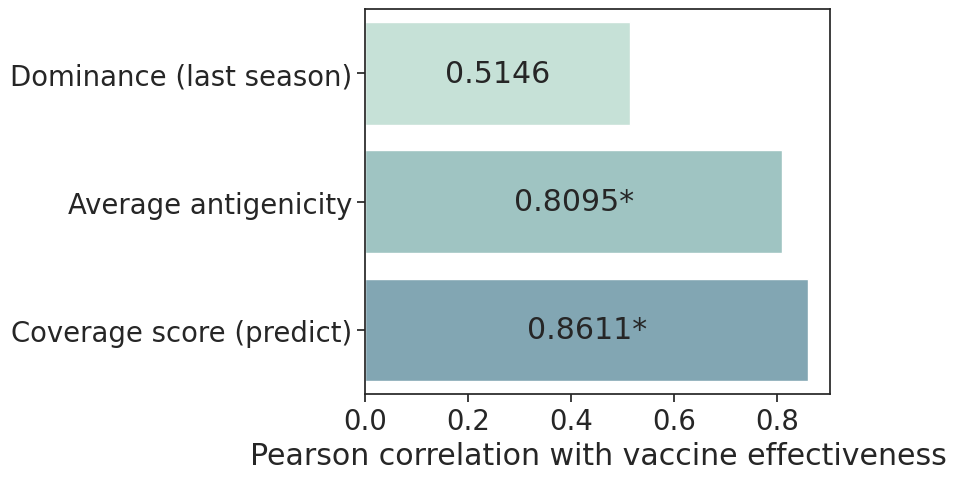

In [16]:

model_list_1 = [
                "Dominance (last)", 
                 "HI median", 
                "Escapability score (prediction)" , 
   
               ]

_models_results = models_results[models_results["model"].isin(model_list_1)]
_models_results = _models_results.set_index('model', drop=False)
_models_results = _models_results.reindex(model_list_1)

_models_results.loc['Dominance (last)','model'] = 'Dominance (last season)'
_models_results.loc['Escapability score (prediction)','model'] = 'Coverage score (predict)'
_models_results.loc["HI median",'model'] = 'Average antigenicity'

_models_results[""] = _models_results["model"]

fig, ax = plt.subplots()
fig.set_size_inches(6, 5)

ax = sns.barplot(_models_results, 
                 x="Pearson", y="", orient="h", palette=sns.cubehelix_palette(start=.5, rot=-.5, dark=.5, n_colors=4),
                 ax=ax
                )


for i in ax.containers:
    display_labels = []
    for value, p in zip(_models_results["Pearson"], _models_results["Pearson P"]):
        if p < 0.05:
            display_labels.append("%.4f*" % value)
        else:
            display_labels.append("%.4f" % value)
    ax.bar_label(i,labels=display_labels, label_type="center")
    
ax.set_xlabel("Pearson correlation with vaccine effectiveness")

plt.savefig("figs/pearson_ve_all_models.pdf", format='pdf', bbox_inches='tight')

plt.show()

2.268692426445239 0.026499240881812592


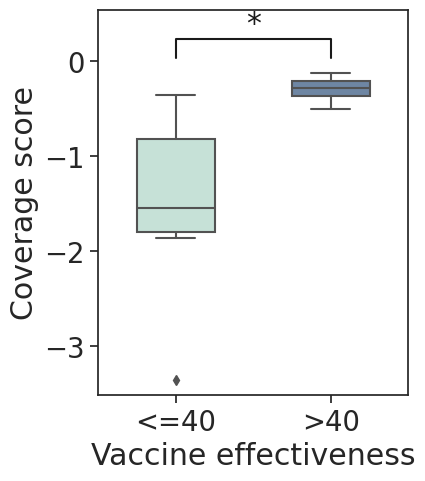

In [18]:
res["Vaccine effectiveness"] = [">40" if x > 40 else "<=40" for x in res["ve"]]

fig, ax = plt.subplots()
fig.set_size_inches(4, 5)

ax = sns.boxplot(data=res[res['model'] == 'Escapability score (prediction)'], 
            x="Vaccine effectiveness", y="score", ax=ax,
                 palette=sns.cubehelix_palette(start=.5, rot=-.5, dark=.5, n_colors=2), width=0.5)
ax.set_ylabel("Coverage score")

_res = res[res['model'] == 'Escapability score (prediction)']

t_statistic, p_value = stats.ttest_ind(_res[_res["Vaccine effectiveness"] == ">40"]["score"], 
                                       _res[_res["Vaccine effectiveness"] == "<=40"]["score"], alternative='greater')

print(t_statistic, p_value)

# Define a function to annotate the plot
def annotate_significance(ax, x1, x2, y, p_value):
    if p_value < 0.001:
        label = '***'
    elif p_value < 0.01:
        label = '**'
    elif p_value < 0.05:
        label = '*'
    else:
        label = 'ns'  # not significant

    ax.plot([x1, x1, x2, x2], [y, y + 0.2, y + 0.2, y], lw=1.5, c='k')
    ax.text((x1 + x2) * 0.5, y + 0.2, label, ha='center', va='bottom', color='k')

# Set y-limit higher to accommodate the annotation
ylim = ax.get_ylim()
ax.set_ylim([ylim[0], ylim[1] + 0.5])

# Add annotation
annotate_significance(ax, 0, 1, ylim[1], p_value)

plt.savefig("figs/ve_pred_boxplot_with_pvalue.pdf", format='pdf', bbox_inches='tight')

plt.show()